In [5]:
import os
from tabulate import tabulate
from bs4 import BeautifulSoup
from tabulate import tabulate

class JEMHEphemeraDoc:
    """
        Data members: (should be self explanatory)
        fileName            | str
        filesDir            | str
        year                | int
        placeOfPublication  | str
        text                | str list
        raw_len             | int (character count of doc body)
        """

    """
    JEMHDocParser is used to read the XML files where ephemera from JEMH corpus are stored.
    """

    # inner class to read XML files of ephemera
    class JEMHEphemeraDocParser:
        @staticmethod
        def createSoup(fileName, fileDir):
            infile = open(fileDir + "/" + fileName, "r")
            soup = BeautifulSoup(infile.read(), 'xml')

            return soup

        @staticmethod
        def parseMetadata(fileName, fileDir):

            soup = JEMHEphemeraDoc.JEMHEphemeraDocParser.createSoup(fileName, fileDir)
            
            date = soup.find('date')
            year = int(date['when'][0:4])

            # xml address to place of publication
            placeOfPublication = soup.find('pubPlace').get_text()

            return year, placeOfPublication

        @staticmethod
        def parseText(fileName, fileDir):
            soup = JEMHEphemeraDoc.JEMHEphemeraDocParser.createSoup(fileName, fileDir)
            texts = soup.find_all('p')
            corp = [text.get_text() for text in texts]
            return corp
        
                
        @staticmethod
        def getRaw_Len(sentence_list):
            charCount = 0
            for sentence in sentence_list:
                charCount += len(sentence)
                
            return charCount

    def __init__(self, fileName, fileDir):
        self.fileName = fileName
        self.fileDir = fileDir

        self.year, self.placeOfPublication = JEMHEphemeraDoc.JEMHEphemeraDocParser.parseMetadata(fileName, fileDir)
        self.text = JEMHEphemeraDoc.JEMHEphemeraDocParser.parseText(fileName, fileDir)
        self.raw_len = JEMHEphemeraDoc.JEMHEphemeraDocParser.getRaw_Len(self.text)

    def __iter__(self):
        return (t for t in self.fileName)

    def __str__(self):
        file = self.fileName + '\n'
        year_and_place = self.placeOfPublication + ", " + str(self.year) + '\n'
        body = ""
        for t in self.text:
            body += t + '\n'

        return file + year_and_place + body

    # Accessors
    def getFileName(self):
        return self.fileName

    def getFileDir(self):
        return self.fileDir

    def getYear(self):
        return self.year

    def getPlaceOfPublication(self):
        return self.placeOfPublication

    def getText(self):
        return self.text
    
    def getRaw_Len(self):
        return self.raw_len

    def getMetadata(self):
        return self.fileName, self.year, self.placeOfPublication

In [8]:
import pandas as pd

class JEMHEphemeraFrame:
    
    def __init__(self, fileDir):
        if type(fileDir) == str:
            self.docs = [JEMHEphemeraDoc(file, fileDir) for file in os.listdir(fileDir) if file.endswith('.xml')]
        elif type(fileDir) == list:
            self.docs = [file for file in fileDir]
        else:
            self.docs = []
         
        fileNames = [doc.getFileName() for doc in self.docs]
        fileDirs = [doc.getFileDir() for doc in self.docs]
        years = [doc.getYear() for doc in self.docs]
        PlacesofPublication = [doc.getPlaceOfPublication() for doc in self.docs]
        texts = [doc.getText() for doc in self.docs]
        raw_lens = [doc.getRaw_Len() for doc in self.docs]
        
        dfData = {'fileName' : fileNames, 'fileDir' : fileDirs, 'Year' : years, 'Place of Pub' : PlacesofPublication,
                 'Raw Length' : raw_lens}
        
        self.df = pd.DataFrame(dfData)

    def __str__(self):
        header = ['File Name', 'Year', 'Place']
        return tabulate([doc.getMetadata() for doc in self.docs], header)

    def __iter__(self):
        return [doc for doc in self.docs]

    def getDocs(self):
        return self.docs
    
    def getFrame(self):
        return self.df

    def filterYear(self, year):
        return JEMHFrame([doc for doc in self.docs if doc.getYear() == year])

    def filterBetweenYears(self, startYear, endYear):
        return JEMHEphemeraFrame([doc for doc in self.docs if doc.getYear() in range(startYear, endYear)])

    def filterBeforeYear(self, endYear):
        return JEMHEphemeraFrame([doc for doc in self.docs if doc.getYear() < endYear])

    def filterAfterYear(self, startYear):
        return JEMHEphemeraFrame([doc for doc in self.docs if doc.getYear() >= startYear])


In [9]:
TESTDIR_EPHEMERA = 'JEMHCorpus/ephemera/street_ads/TEI'

testCorpus_Ephemera = JEMHEphemeraFrame(TESTDIR_EPHEMERA)

print(testCorpus_Ephemera.getFrame())

          fileName                             fileDir  Year Place of Pub  \
0    700174267.xml  JEMHCorpus/ephemera/street_ads/TEI  1928         חיפה   
1    700173520.xml  JEMHCorpus/ephemera/street_ads/TEI  1946         חיפה   
2    700173534.xml  JEMHCorpus/ephemera/street_ads/TEI  1947         חיפה   
3    700174313.xml  JEMHCorpus/ephemera/street_ads/TEI  1929         חיפה   
4    700173440.xml  JEMHCorpus/ephemera/street_ads/TEI  1946         חיפה   
..             ...                                 ...   ...          ...   
234  700172633.xml  JEMHCorpus/ephemera/street_ads/TEI  1960         חיפה   
235  700173263.xml  JEMHCorpus/ephemera/street_ads/TEI  1946         חיפה   
236  700173505.xml  JEMHCorpus/ephemera/street_ads/TEI  1944         חיפה   
237  700174097.xml  JEMHCorpus/ephemera/street_ads/TEI  1954         חיפה   
238  700173707.xml  JEMHCorpus/ephemera/street_ads/TEI  1941         חיפה   

     Raw Length  
0          1915  
1           556  
2           550  
3  

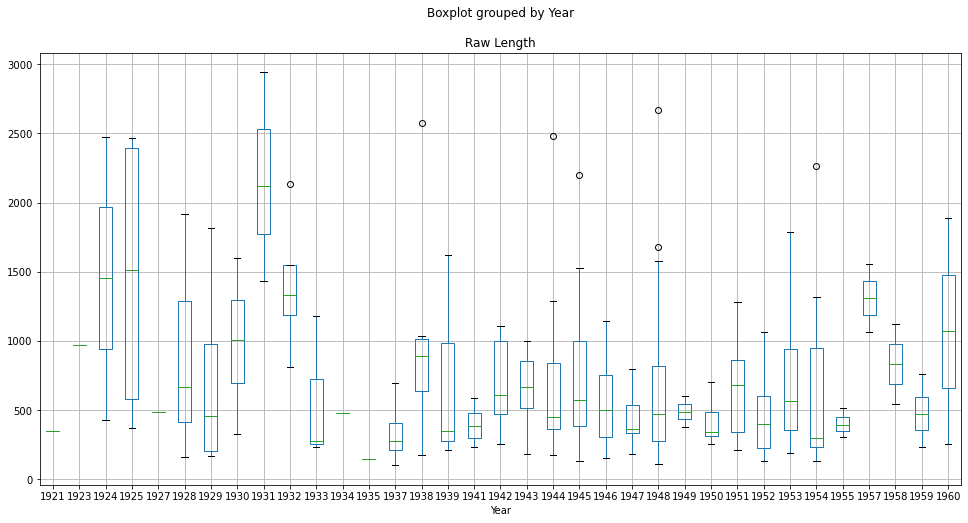

In [13]:
import matplotlib.pyplot as plt

#relationship between char size and year
frame = testCorpus_Ephemera.getFrame()
fig, ax = plt.subplots(figsize=(16,8))

frame.boxplot(column='Raw Length', by='Year', ax=ax)

plt.show()